In [0]:
import argparse
import tensorflow as tf
import sys
import os.path
import tensorflow as tf
import time
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
#sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
#wk_dir = os.path.dirname(os.path.realpath('__file__'))
#print(wk_dir)

Recommendation is viewed as information retrieval task: Retrieve (recommend) all items which are predicted to be “good”.

Precision: a measure of exactness, determines the fraction of relevant items retrieved out of all items retrieved
Recall: a measure of completeness, determines the fraction of relevant items retrieved out of all relevant items
typically when a recommender system is tuned to increase precision, recall decreases as a result (or vice versa)
The F1 Metric attempts to combine Precision and Recall into a single value for comparison purposes. The F1 Metric gives equal weight to precision and recall

Rank metrics extend recall and precision to take the positions of correct items in a ranked list into account
Relevant items are more useful when they appear earlier in the recommendation list
Particularly important in recommender systems as lower ranked items may be overlooked by users

Discounted cumulative gain (DCG) is a measure of ranking quality. In information retrieval, it is often used to measure effectiveness of web search engine algorithms or related applications. Using a graded relevance scale of documents in a search-engine result set, DCG measures the usefulness, or gain, of a document based on its position in the result list. The gain is accumulated from the top of the result list to the bottom, with the gain of each result discounted at lower ranks.

In [0]:
# efficient version
def precision_recall_ndcg_at_k(k, rankedlist, test_matrix):
    idcg_k = 0
    dcg_k = 0
    n_k = k if len(test_matrix) > k else len(test_matrix)
    for i in range(n_k):
        idcg_k += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        dcg_k += 1 / math.log(hits[c][0] + 2, 2)

    return float(count / k), float(count / len(test_matrix)), float(dcg_k / idcg_k)


def map_mrr_ndcg(rankedlist, test_matrix):
    ap = 0
    map = 0
    dcg = 0
    idcg = 0
    mrr = 0
    for i in range(len(test_matrix)):
        idcg += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        ap += (c + 1) / (hits[c][0] + 1)
        dcg += 1 / math.log(hits[c][0] + 2, 2)

    if count != 0:
        mrr = 1 / (hits[0][0] + 1)

    if count != 0:
        map = ap / count

    return map, mrr, float(dcg / idcg)


def evaluate(self):
    
    pred_ratings_10 = {}
    pred_ratings_5 = {}
    pred_ratings = {}
    ranked_list = {}
    p_at_5 = []
    p_at_10 = []
    r_at_5 = []
    r_at_10 = []
    map = []
    mrr = []
    ndcg = []
    ndcg_at_5 = []
    ndcg_at_10 = []
    for u in self.test_users:
        user_ids = []
        user_neg_items = self.neg_items[u]
        item_ids = []
        # scores = []
        for j in user_neg_items:
            item_ids.append(j)
            user_ids.append(u)

        scores = self.predict(user_ids, item_ids)
        # print(type(scores))
        # print(scores)
        # print(np.shape(scores))
        # print(ratings)
        neg_item_index = list(zip(item_ids, scores))

        ranked_list[u] = sorted(neg_item_index, key=lambda tup: tup[1], reverse=True)
        pred_ratings[u] = [r[0] for r in ranked_list[u]]
        pred_ratings_5[u] = pred_ratings[u][:5]
        pred_ratings_10[u] = pred_ratings[u][:10]

        p_5, r_5, ndcg_5 = precision_recall_ndcg_at_k(5, pred_ratings_5[u], self.test_data[u])
        p_at_5.append(p_5)
        r_at_5.append(r_5)
        ndcg_at_5.append(ndcg_5)
        p_10, r_10, ndcg_10 = precision_recall_ndcg_at_k(10, pred_ratings_10[u], self.test_data[u])
        p_at_10.append(p_10)
        r_at_10.append(r_10)
        ndcg_at_10.append(ndcg_10)
        map_u, mrr_u, ndcg_u = map_mrr_ndcg(pred_ratings[u], self.test_data[u])
        map.append(map_u)
        mrr.append(mrr_u)
        ndcg.append(ndcg_u)

    print("-----------------------------------------------------")
    #print("precision@10: " + str(np.mean(p_at_10)))
    #print("recall@10: " + str(np.mean(r_at_10)))
    #print("precision@5: " + str(np.mean(p_at_5)))
    #print("recall@5: " + str(np.mean(r_at_5)))
    #print("map: " + str(np.mean(map)))
    #print("mrr: " + str(np.mean(mrr)))
    #print("ndcg: " + str(np.mean(ndcg)))
    #print("ndcg@5: " + str(np.mean(ndcg_at_5)))
    #print("ndcg@10: " + str(np.mean(ndcg_at_10)))
    
    return np.mean(p_at_5), np.mean(r_at_5)

In [0]:
class ICDAE():
    '''
    Based on CDAE and I-AutoRec, I designed the following item based CDAE, it seems to perform better than CDAE slightly.
    '''

    def __init__(self, sess, num_user, num_item, learning_rate=1e-3, reg_rate=0.1, epoch=50, batch_size=1024,
                 verbose=False, T=10, display_step=10):
        self.learning_rate = learning_rate
        self.epochs = epoch
        self.batch_size = batch_size
        self.reg_rate = reg_rate
        self.sess = sess
        self.num_user = num_user
        self.num_item = num_item
        self.verbose = verbose
        self.T = T
        self.display_step = display_step
        print("Item based CDAE.")

    def build_network(self, hidden_neuron=500, corruption_level=0):
        self.corrupted_interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.item_id = tf.placeholder(dtype=tf.int32, shape=[None])
        self.corruption_level = corruption_level

        W = tf.Variable(tf.random_normal([self.num_user, hidden_neuron], stddev=0.01))
        W_prime = tf.Variable(tf.random_normal([hidden_neuron, self.num_user], stddev=0.01))
        V = tf.Variable(tf.random_normal([self.num_item, hidden_neuron], stddev=0.01))

        b = tf.Variable(tf.random_normal([hidden_neuron], stddev=0.01))
        b_prime = tf.Variable(tf.random_normal([self.num_user], stddev=0.01))
        # print(np.shape(tf.matmul(self.corrupted_interact_matrix, W)))
        # print(np.shape( tf.nn.embedding_lookup(V, self.item_id)))
        layer_1 = tf.sigmoid(tf.matmul(self.corrupted_interact_matrix, W) + b)
        self.layer_2 = tf.sigmoid(tf.matmul(layer_1, W_prime) + b_prime)

        self.loss = - tf.reduce_sum(
            self.interact_matrix * tf.log(self.layer_2) + (1 - self.interact_matrix) * tf.log(1 - self.layer_2)) \
                    + self.reg_rate * (
        tf.nn.l2_loss(W) + tf.nn.l2_loss(W_prime) + tf.nn.l2_loss(b) + tf.nn.l2_loss(b_prime))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

    def prepare_data(self, train_data, test_data):
        self.train_data = self._data_process(train_data).transpose()
        self.neg_items = self._get_neg_items(train_data)
        self.num_training = self.num_item
        self.total_batch = int(self.num_training / self.batch_size)
        self.test_data = test_data
        self.test_users = set([u for u in self.test_data.keys() if len(self.test_data[u]) > 0])
        print("data preparation finished.")

    def train(self):

        idxs = np.random.permutation(self.num_training)  # shuffled ordering

        for i in range(self.total_batch):
            start_time = time.time()
            if i == self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size:]
            elif i < self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size: (i + 1) * self.batch_size]

            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={
                self.corrupted_interact_matrix: self._get_corrupted_input(self.train_data[batch_set_idx, :],
                                                                          self.corruption_level),
                self.interact_matrix: self.train_data[batch_set_idx, :],
                self.item_id: batch_set_idx
                })
            if self.verbose and i % self.display_step == 0:
                print("Index: %04d; cost= %.9f" % (i + 1, np.mean(loss)))
                if self.verbose:
                    print("one iteration: %s seconds." % (time.time() - start_time))

    def test(self):
        self.reconstruction = self.sess.run(self.layer_2, feed_dict={self.corrupted_interact_matrix: self.train_data,
                                                                     self.item_id: range(self.num_item)}).transpose()
        
        precision, recall = evaluate(self)
        return precision, recall, self.reconstruction

    def execute(self, train_data, test_data):
        self.prepare_data(train_data, test_data)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        precision =[]
        recall =[]
        error =[]
        for epoch in range(self.epochs):
            self.train()
            if (epoch) % self.T == 0:
                prec, rec , err= self.test()
                print("Epoch: %04d; " % (epoch), end='')
                precision.append(prec)
                recall.append(rec)
                error.append(np.mean(err))
        return precision, recall, error

    def save(self, path):
        saver = tf.train.Saver()
        saver.save(self.sess, path)

    def predict(self, user_id, item_id):
        return np.array(self.reconstruction[np.array(user_id), np.array(item_id)])

    def _data_process(self, data):
        return np.asmatrix(data)

    def _get_neg_items(self, data):
        neg_items = {}
        for u in range(self.num_user):
            neg_items[u] = [k for k, i in enumerate(data[u]) if data[u][k] == 0]
            # print(neg_items[u])

        return neg_items

    def _get_corrupted_input(self, input, corruption_level):
        return np.random.binomial(n=1, p=1 - corruption_level) * input


In [0]:
def load_data_all(path="https://raw.githubusercontent.com/cheungdaven/DeepRec/master/data/ml100k/movielens_100k.dat", header=['user_id', 'item_id', 'rating', 'time'],
                  test_size=0.2, sep="\t"):
    df = pd.read_csv(path, sep=sep, names=header, engine='python')

    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    train_data, test_data = train_test_split(df, test_size=test_size)
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    
    train_row = []
    train_col = []
    train_rating = []

    train_dict = {}
    for line in train_data.itertuples():
        u = line[1] - 1
        i = line[2] - 1
        train_dict[(u, i)] = 1

    for u in range(n_users):
        for i in range(n_items):
            train_row.append(u)
            train_col.append(i)
            if (u, i) in train_dict.keys():
                train_rating.append(1)
            else:
                train_rating.append(0)
    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))
    all_items = set(np.arange(n_items))

    neg_items = {}
    train_interaction_matrix = []
    for u in range(n_users):
        neg_items[u] = list(all_items - set(train_matrix.getrow(u).nonzero()[1]))
        train_interaction_matrix.append(list(train_matrix.getrow(u).toarray()[0]))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        test_row.append(line[1] - 1)
        test_col.append(line[2] - 1)
        test_rating.append(1)
    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

    test_dict = {}
    for u in range(n_users):
        test_dict[u] = test_matrix.getrow(u).nonzero()[1]

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)

    return train_interaction_matrix, test_dict, n_users, n_items


def load_data_neg(path="../data/ml100k/movielens_100k.dat", header=['user_id', 'item_id', 'rating', 'category'],
                  test_size=0.2, sep="\t"):
    df = pd.read_csv(path, sep=sep, names=header, engine='python')

    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    train_data, test_data = train_test_split(df, test_size=test_size)
    train_data = pd.DataFrame(train_data)
    
    test_data = pd.DataFrame(test_data)
    print(test_data.head)
    train_row = []
    train_col = []
    train_rating = []

    for line in train_data.itertuples():
        u = line[1] - 1
        i = line[2] - 1
        train_row.append(u)
        train_col.append(i)
        train_rating.append(line[3])
    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))

    # all_items = set(np.arange(n_items))
    # neg_items = {}
    # for u in range(n_users):
    #     neg_items[u] = list(all_items - set(train_matrix.getrow(u).nonzero()[1]))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        test_row.append(line[1] - 1)
        test_col.append(line[2] - 1)
        test_rating.append(line[3])
    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

    test_dict = {}
    for u in range(n_users):
        test_dict[u] = test_matrix.getrow(u).nonzero()[1]

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix.todok(), test_dict, n_users, n_items


def load_data_separately(path_train=None, path_test=None, path_val=None, header=['user_id', 'item_id', 'rating'],
                         sep=" ", n_users=0, n_items=0):
    n_users = n_users
    n_items = n_items
    print("start")
    train_matrix = None
    if path_train is not None:
        train_data = pd.read_csv(path_train, sep=sep, names=header, engine='python')
        print("Load data finished. Number of users:", n_users, "Number of items:", n_items)

        train_row = []
        train_col = []
        train_rating = []

        for line in train_data.itertuples():
            u = line[1]  # - 1
            i = line[2]  # - 1
            train_row.append(u)
            train_col.append(i)
            train_rating.append(1)

        train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    test_dict = None
    if path_test is not None:
        test_data = pd.read_csv(path_test, sep=sep, names=header, engine='python')
        test_row = []
        test_col = []
        test_rating = []
        for line in test_data.itertuples():
            test_row.append(line[1])
            i = line[2]  # - 1
            test_col.append(i)
            test_rating.append(1)

        test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

        test_dict = {}
        for u in range(n_users):
            test_dict[u] = test_matrix.getrow(u).nonzero()[1]
    all_items = set(np.arange(n_items))
    train_interaction_matrix = []
    for u in range(n_users):
        train_interaction_matrix.append(list(train_matrix.getrow(u).toarray()[0]))

    if path_val is not None:
        val_data = pd.read_csv(path_val, sep=sep, names=header, engine='python')

    print("end")
    return train_interaction_matrix, test_dict, n_users, n_items


In [89]:
import matplotlib.pyplot as plt

model ='CDAE'
epochs = 25
num_factors = 10
display_step = 10
batch_size = 1024  # 128 for unlimpair
learning_rate = 1e-3  # 1e-4 for unlimpair
reg_rate = 0.1  # 0.01 for unlimpair
train_data, test_data, n_user, n_item = load_data_all(test_size=0.2, sep="\t")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    model = ICDAE(sess, n_user, n_item)
    model.build_network()
    precision, recall, error = model.execute(train_data, test_data)
    
print('Done!!!')
    
    


Load data finished. Number of users: 943 Number of items: 1682
Item based CDAE.
data preparation finished.
Epoch: 0000; Epoch: 0010; Epoch: 0020; Epoch: 0030; Epoch: 0040; Done!!!


**Precision**

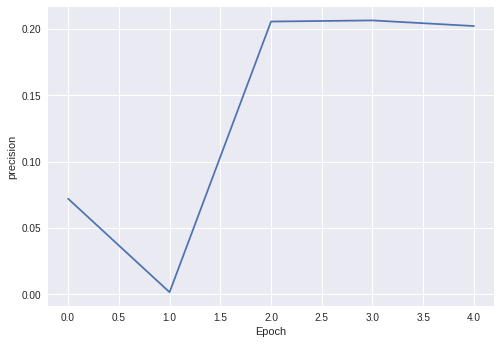

In [90]:
plt.plot(precision)
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.show()
    

**Error**

[0.43650457, 0.069302395, 0.050027512, 0.0728909, 0.059047386]


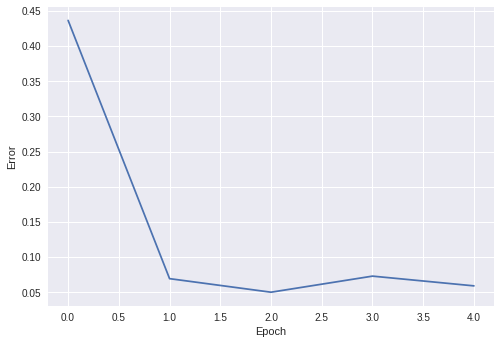

In [91]:
print(error)
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()